Unsupervised algorithm

Can be used for dimensionality reduction and can work well on non linear datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras.models import Model 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [2]:
!wget http://www.timeseriesclassification.com/Downloads/ECG5000.zip
!unzip ECG5000.zip

--2021-05-26 23:11:27--  http://www.timeseriesclassification.com/Downloads/ECG5000.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip’

ECG5000.zip         100%[===================>]  10.12M  13.1MB/s    in 0.8s    

2021-05-26 23:11:28 (13.1 MB/s) - ‘ECG5000.zip’ saved [10614407/10614407]

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


In [ ]:
!cat ECG5000_TRAIN.txt ECG5000_TEST.txt > ecg_final.txt

In [12]:
df =  pd.read_csv('ecg_final.txt', sep='  ', header=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [14]:
df.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
           dtype='int64', length=141)

In [15]:
df = df.add_prefix('c')

In [16]:
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

In [17]:
df.describe()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,...,c101,c102,c103,c104,c105,c106,c107,c108,c109,c110,c111,c112,c113,c114,c115,c116,c117,c118,c119,c120,c121,c122,c123,c124,c125,c126,c127,c128,c129,c130,c131,c132,c133,c134,c135,c136,c137,c138,c139,c140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,-0.936082,-0.586326,-0.434430,-0.337621,-0.258235,-0.184443,-0.120015,-0.070396,-0.041849,-0.037049,-0.041243,-0.048908,-0.060176,-0.070725,-0.085491,-0.101144,-0.116070,-0.134461,-0.155811,-0.177542,-0.200685,-0.224244,-0.246686,-0.271476,-0.290321,-0.304461,-0.315111,-0.316851,-0.313070,-0.303238,...,0.946527,1.051337,1.138071,1.187551,1.201909,1.190866,1.154605,1.086347,0.986863,0.864419,0.720300,0.570000,0.428955,0.319734,0.242586,0.181059,0.134708,0.109781,0.093630,0.081028,0.065780,0.047326,0.025409,0.004531,-0.009790,-0.019087,-0.026208,-0.029561,0.000637,0.086588,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,0.657945,0.592049,0.493606,0.426206,0.393553,0.382488,0.386315,0.400830,0.415267,0.423797,0.429734,0.434976,0.441768,0.447727,0.454600,0.461603,0.472726,0.483574,0.492048,0.503468,0.516169,0.530030,0.543061,0.552285,0.560649,0.564906,0.566459,0.560789,0.548964,0.536229,...,0.520027,0.574633,0.614855,0.623050,0.608319,0.582721,0.553923,0.531272,0.507226,0.485600,0.483479,0.511334,0.546391,0.565580,0.571998,0.573798,0.584480,0.589680,0.591613,0.597117,0.603953,0.610288,0.619812,0.633101,0.649239,0.667657,0.680713,0.693871,0.751844,0.920052,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,-4.040526,-3.724538,-3.264576,-3.222345,-3.263484,-3.219212,-3.202187,-3.147504,-3.459917,-4.102102,-4.311241,-4.099888,-3.614973,-3.822298,-3.795567,-3.690817,-3.542485,-3.631665,-3.587112,-3.452215,-4.074752,-4.137454,-4.059662,-3.626646,-2.829471,-3.585866,-4.003401,-3.900724,-3.325329,...,-2.662170,-2.634950,-2.634768,-2.591663,-2.446476,-2.234175,-2.431403,-2.681604,-2.864706,-3.415656,-3.497624,-3.091282,-2.608510,-2.383204,-2.678883,-3.305661,-3.179590,-3.311559,-3.501555,-4.007212,-4.199563,-3.335678,-3.127603,-3.042532,-3.116177,-3.972320,-4.754057,-4.290016,-3.802469,-4.014642,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,-1.362068,-0.935730,-0.704797,-0.557938,-0.457267,-0.392099,-0.346567,-0.329879,-0.332123,-0.342879,-0.359587,-0.373523,-0.392615,-0.415157,-0.441247,-0.470702,-0.501586,-0.538227,-0.570103,-0.616792,-0.650610,-0.695386,-0.735151,-0.770997,-0.799982,-0.8121

In [18]:
train_x, test_x, train_y, test_y = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=True)

In [20]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_x)

In [23]:
train_x_scaled = data_scaled.transform(train_x)
test_x_scaled = data_scaled.transform(test_x)

In [29]:
normal_train_data = pd.DataFrame(train_x_scaled).add_prefix('c').query("c0==0").values[:,1:]
anomaly_train_data = pd.DataFrame(train_x_scaled).add_prefix('c').query("c0>0").values[:,1:]

In [30]:
normal_test_data = pd.DataFrame(test_x_scaled).add_prefix('c').query("c0==0").values[:,1:]
anomaly_test_data = pd.DataFrame(test_x_scaled).add_prefix('c').query("c0>0").values[:,1:]

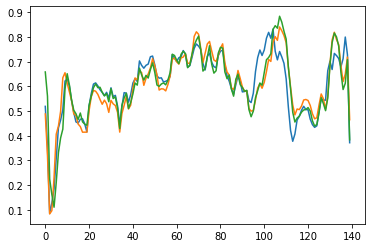

In [31]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])

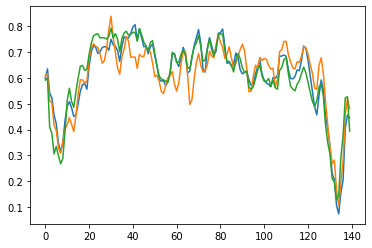

In [32]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])

In [33]:
# DL model can be used

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(140, activation='sigmoid'))

In [34]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu')])
    
    self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(140, activation='sigmoid')])
    
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded 

In [35]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

model.compile(optimizer='adam', loss='mae')

In [37]:
history = model.fit(normal_train_data, normal_train_data,
                    epochs=50, batch_size=128,
                    validation_data=(train_x_scaled[:,1:], train_x_scaled[:,1:]),
                    shuffle=True,
                    callbacks=[early_stopping])

Epoch 1/50
19/19 [==============================] - 1s 14ms/step - loss: 0.1229 - val_loss: 0.1050
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0746 - val_loss: 0.0800
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0504 - val_loss: 0.0747
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0464 - val_loss: 0.0748
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0458 - val_loss: 0.0736
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0456 - val_loss: 0.0735
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0455 - val_loss: 0.0729
Epoch 8/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0454 - val_loss: 0.0727
Epoch 9/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0452 - val_loss: 0.0727
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.0722
Epoch 11/50
19/19 

In [38]:
encoder_out = model.encoder(normal_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

In [39]:
encoder_out.shape

(599, 8)

In [40]:
decoder_out.shape

(599, 140)

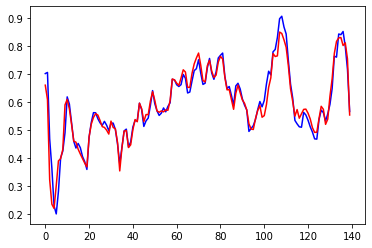

In [41]:
plt.plot(normal_test_data[0],'b')
plt.plot(decoder_out[0], 'r')

In [43]:
encoder_out_a = model.encoder(anomaly_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

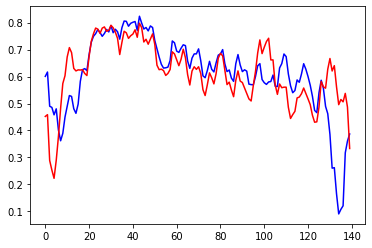

In [44]:
plt.plot(anomaly_test_data[0],'b')
plt.plot(decoder_out_a[0], 'r')

(array([13., 51., 88., 96., 73., 54., 56., 35., 26., 21., 26., 17., 12.,
        11.,  4.,  2.,  3.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01077532, 0.01362438, 0.01647343, 0.01932249, 0.02217154,
        0.0250206 , 0.02786965, 0.03071871, 0.03356777, 0.03641682,
        0.03926588, 0.04211493, 0.04496399, 0.04781304, 0.0506621 ,
        0.05351115, 0.05636021, 0.05920927, 0.06205832, 0.06490738,
        0.06775643, 0.07060549, 0.07345454, 0.0763036 , 0.07915265,
        0.08200171, 0.08485077, 0.08769982, 0.09054888, 0.09339793,
        0.09624699, 0.09909604, 0.1019451 , 0.10479415, 0.10764321,
        0.11049227, 0.11334132, 0.11619038, 0.11903943, 0.12188849,
        0.12473754, 0.1275866 , 0.13043565, 0.13328471, 0.13613377,
        0.13898282, 0.14183188, 0.14468093, 0.14752999, 0.15037904,
        0.1532281 ]),
 <a list of 50

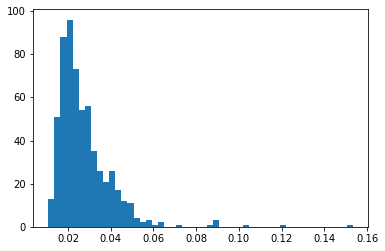

In [46]:
reconstructs = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructs, normal_test_data)

plt.hist(train_loss, bins=50)

In [47]:
np.mean(train_loss)

0.027516718305749678

In [48]:
np.std(train_loss)

0.013268409510320149

In [49]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)

In [50]:
threshold

0.054053537326389976

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  3.,  4.,  3.,
         6., 14., 18., 23., 30., 32., 25., 47., 36., 38., 29., 22., 26.,
        11., 12.,  3.,  2.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.]),
 array([0.03384898, 0.03621877, 0.03858857, 0.04095836, 0.04332816,
        0.04569796, 0.04806775, 0.05043755, 0.05280734, 0.05517714,
        0.05754693, 0.05991673, 0.06228652, 0.06465632, 0.06702611,
        0.06939591, 0.0717657 , 0.0741355 , 0.07650529, 0.07887509,
        0.08124488, 0.08361468, 0.08598447, 0.08835427, 0.09072407,
        0.09309386, 0.09546366, 0.09783345, 0.10020325, 0.10257304,
        0.10494284, 0.10731263, 0.10968243, 0.11205222, 0.11442202,
        0.11679181, 0.11916161, 0.1215314 , 0.1239012 , 0.12627099,
        0.12864079, 0.13101058, 0.13338038, 0.13575018, 0.13811997,
        0.14048977, 0.14285956, 0.14522936, 0.14759915, 0.14996895,
        0.15233874]),
 <a list of 50

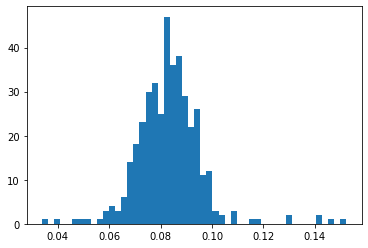

In [54]:
reconstructs_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstructs_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)

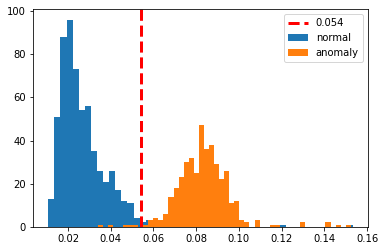

In [56]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed',
            label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.show()

In [57]:
np.mean(train_loss_a)

0.08333364141515562

In [58]:
np.std(train_loss_a)

0.012639546047470689